In [1]:
import warnings
warnings.simplefilter('ignore')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge, ARDRegression, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
df = pd.read_csv('../datasets/processed_dataset.csv')
df.head()

,Course Code,Course Title,Student Number,Department Code,Course Level,Letter Grade,Status,GPA,Standing,Completed Credits,Completed ECTS,GPA Student - Subject,Avg. Grade - Taken,Avg. Grade - Students_Subject,Semester,Theoritical,Practical,Course Credit,ECTS,Course Year
0,MGT 511,Küresel Yönetim Düşüncesi,1182,MBA/NT,Graduate,A-,Successful,3.54,Freshman,15,25,3.540000,3.576471,3.324211,2011 - Fall,3,0,3,5,5
1,UNI 123,Textual Analysis and Effective Communication,134,EE,Undergraduate,C-,Successful,3.67,Freshman,18,30,3.666667,2.120833,2.703226,2011 - Fall,3,0,3,5,1
2,UNI 115,Turkish for International Students I,217,CTV,Undergraduate,A-,Successful,3.70,Freshman,3,5,3.700000,3.900000,2.703226,2011 - Fall,3,0,3,5,1
3,MGT 511,Küresel Yönetim Düşüncesi,1227,MBA/NT,Graduate,B,Successful,3.00,Freshman,15,25,3.000000,3.576471,3.324211,2011 - Fall,3,0,3,5,5
4,MGT 541,Uluslararası Pazarlama,1225,MBA/NT,Graduate,B+,Successful,3.33,Freshman,9,15,3.333333,3.238095,3.324211,2011 - Fall,3,0,3,5,5


In [3]:
df.drop([df.columns[0], df.columns[1], df.columns[2]], inplace=True, axis=1)   # dropping course details

In [4]:
df = pd.concat([df, pd.get_dummies(df['Course Year'], prefix='Course Year'), pd.get_dummies(df['Department Code'], prefix='Department Code'), pd.get_dummies(df['Course Level'], prefix='Course Level'), pd.get_dummies(df['Standing'], prefix='Standing'), pd.get_dummies(df['Status'], prefix='Status')], axis=1)
df.drop(['Course Year', 'Department Code', 'Course Level', 'Status', 'Standing'], axis=1, inplace=True)

In [5]:
def plot_target_distribution():
    counts = df[['Letter Grade', 'Semester']].groupby('Letter Grade', as_index=False).count()
    counts.plot('Letter Grade', 'Semester', kind='bar', figsize=(7, 3.5), legend=False, color='lightblue')
    y = counts['Semester']
    
    for i, v in enumerate(y):
        plt.text(i-.15, v+250, str(v), rotation=90, fontfamily='serif', fontweight='bold', fontsize=11.5)
    
    plt.ylabel('Count', fontsize=15, fontfamily='serif')
    plt.xlabel('Letter Grade', fontsize=15, fontfamily='serif')
    plt.xticks(fontfamily='serif', fontsize=15)
    plt.yticks(range(0,9001,1500), fontfamily='serif', fontsize=15)
    plt.savefig('target_dist.eps', bbox_inches='tight', dpi=300)

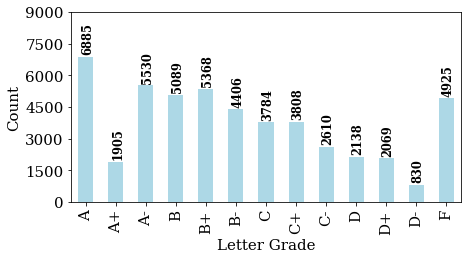

In [6]:
plot_target_distribution()

In [6]:
columns = df.columns

In [7]:
le = LabelEncoder()
le.fit(['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F'])

LabelEncoder()

In [8]:
def standardize(X_train, X_test):
    X_train_cols = X_train.columns
    X_test_cols = X_test.columns
    sc = StandardScaler()
    fitted_sc = sc.fit(X_train)
    X_train_std = pd.DataFrame(fitted_sc.transform(X_train), columns=X_train_cols)
    X_test_std = pd.DataFrame(fitted_sc.transform(X_test), columns=X_test_cols)
    return X_train_std, X_test_std

In [9]:
def get_train_data(df, train_sem, columns):
    dataFrame = pd.DataFrame(columns=columns)
    for sem in train_sem:
        dataFrame = pd.concat([dataFrame, df[df.iloc[:, 7] == sem]], ignore_index=True)
    
    X_train = dataFrame.drop('Semester', axis=1)
    y_train = le.transform(X_train.pop('Letter Grade'))
    return X_train, y_train

In [10]:
def get_error_score(df, columns, model):
    error_scores = {}
    sorted_semesters = sorted(set(df.iloc[:, 7]))
    for sem_idx in range(1, len(sorted_semesters)):
        training_sem = sorted_semesters[:sem_idx]
        test_sem = sorted_semesters[sem_idx]
        X_train, y_train = get_train_data(df, training_sem, columns)
        X_test = df[df.iloc[:, 7] == test_sem]
        X_test.drop('Semester', axis=1, inplace=True)
        y_test = le.transform(X_test.pop('Letter Grade'))
        
        X_train, X_test = standardize(X_train, X_test)
        model.fit(X_train, y_train)
        
        y_pred_test = model.predict(X_test)
        rmse_test = round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 3)
        mae_test = round(mean_absolute_error(y_test, y_pred_test), 3)
        
        y_pred_train = model.predict(X_train)
        rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 3)
        mae_train = round(mean_absolute_error(y_train, y_pred_train),3)
        
        error_scores.setdefault(sem_idx, {})
        error_scores[sem_idx]['rmse'] = [rmse_train, rmse_test]
        error_scores[sem_idx]['mae'] = [mae_train, mae_test]        
        
    return error_scores

In [11]:
def plot_error_score(scores, model_name):
    errors = {}
    for k in sorted(scores):
        for metric in scores[k]:
            errors.setdefault(metric + ' train', [])
            errors[metric + ' train'].append(scores[k][metric][0])
            errors.setdefault(metric + ' test', [])
            errors[metric + ' test'].append(scores[k][metric][1])
    
    x = np.arange(7)
    fig, ax = plt.subplots(figsize=(15, 6))
    rects1 = ax.bar(x - 3*0.15/2, errors['rmse test'], 0.15, label='RMSE - test')
    rects2 = ax.bar(x - 0.15/2, errors['rmse train'], 0.15, label='RMSE - train')
    rects4 = ax.bar(x + 0.15/2, errors['mae train'], 0.15, label='MAE - train')
    rects3 = ax.bar(x + 3*0.15/2, errors['mae test'], 0.15, label='MAE - test')
    
    for i, v in enumerate(errors['rmse test']):
        ax.text(i-0.28, v + 0.07, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold', rotation=90)
    
    for i, v in enumerate(errors['rmse train']):
        ax.text(i-0.12, v + 0.07, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold', rotation=90)
    
    for i, v in enumerate(errors['mae train']):
        ax.text(i+0.025, v + 0.07, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold', rotation=90)

    for i, v in enumerate(errors['mae test']):
        ax.text(i+0.18, v + 0.07, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold', rotation=90)

    ax.set_ylabel('Error', fontsize=22, fontfamily='serif')
    ax.set_title('Error Metrics with N training semesters - ({})'.format(model_name), fontsize=22, fontfamily='serif')
    ax.set_ylim(top=list(ax.get_ylim())[1]+0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(['N={}'.format(i+1) for i in range(7)], fontsize=22, fontfamily='serif')
    ax.set_yticklabels(ax.get_yticks(), fontsize=22, fontfamily='serif')
    ax.tick_params(labelsize=22)
    ax.grid(True)
    ax.legend(prop={'size': 17, 'family': 'serif'}, loc='center', bbox_to_anchor=(0.5, -0.15), ncol=4)

In [12]:
model_results = {}

# Tree Models:
### DecisionTreeRegressor:
* Observations: The model clearly overfits. Hyperparameter tuning shall be applied in next round of analysis.

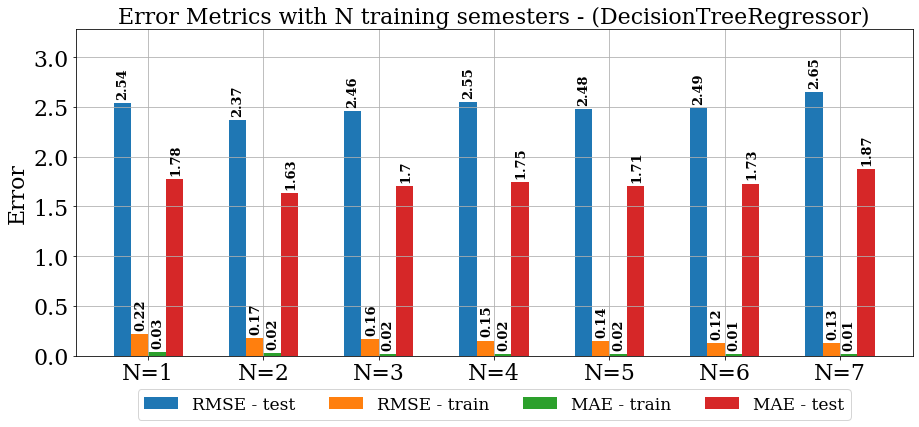

In [13]:
scores = get_error_score(df, columns, DecisionTreeRegressor())
model_results['DecisionTreeRegressor'] = scores
plot_error_score(scores, 'DecisionTreeRegressor')

# Neighbor Models:
### KNeighborsRegressor:
* Observations: The model almost generalizes to the test data but there is high bias.

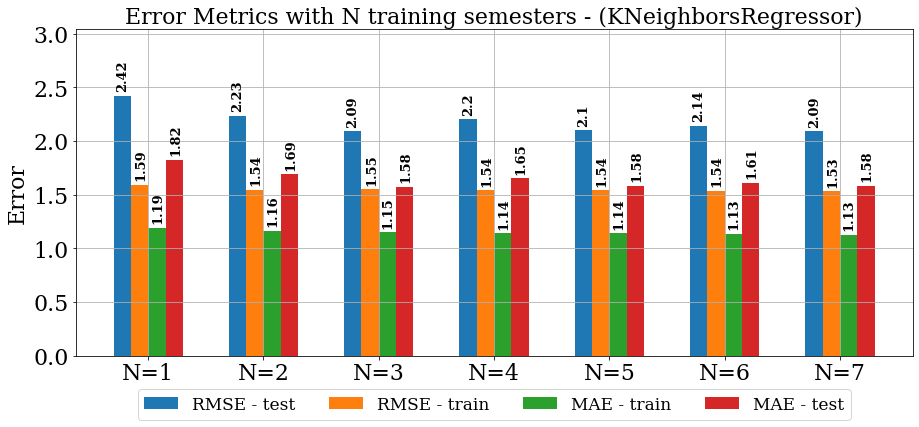

In [14]:
scores = get_error_score(df, columns, KNeighborsRegressor())
model_results['KNeighborsRegressor'] = scores
plot_error_score(scores, 'KNeighborsRegressor')

# Support Vector Machines:
### Support Vector Regressor:
* Observations: The model does not overfit, but there is high bias.

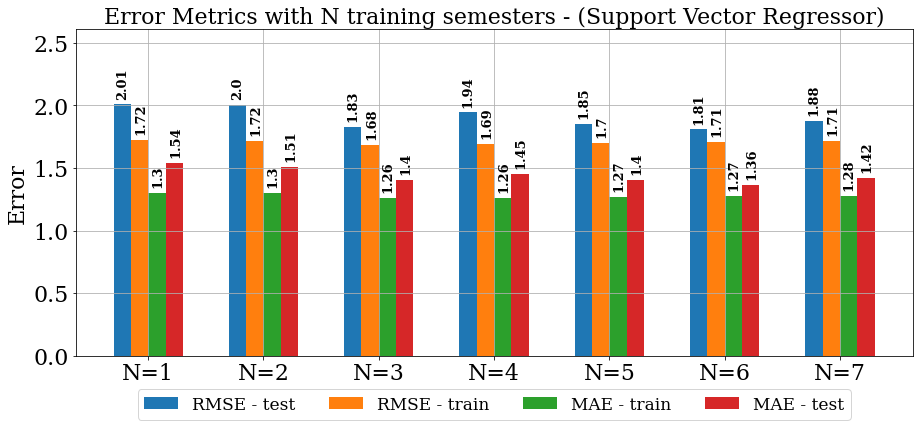

In [15]:
scores = get_error_score(df, columns, SVR())
model_results['SVR'] = scores
plot_error_score(scores, 'Support Vector Regressor')

# Linear Models:
### BayesianRidge:
* Observations: The model does not overfit, but there is high bias.

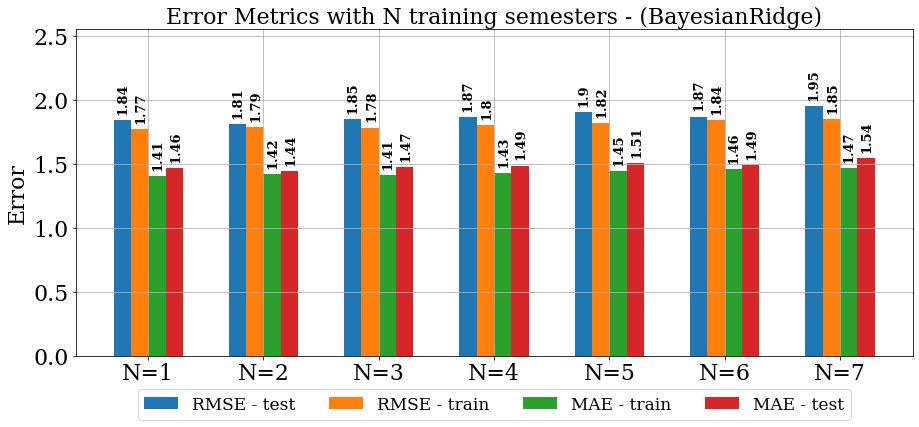

In [16]:
scores = get_error_score(df, columns, BayesianRidge())
model_results['BayesianRidge'] = scores
plot_error_score(scores, 'BayesianRidge')

### Lasso:
* Observations: The model does not overfit but there is high bias.

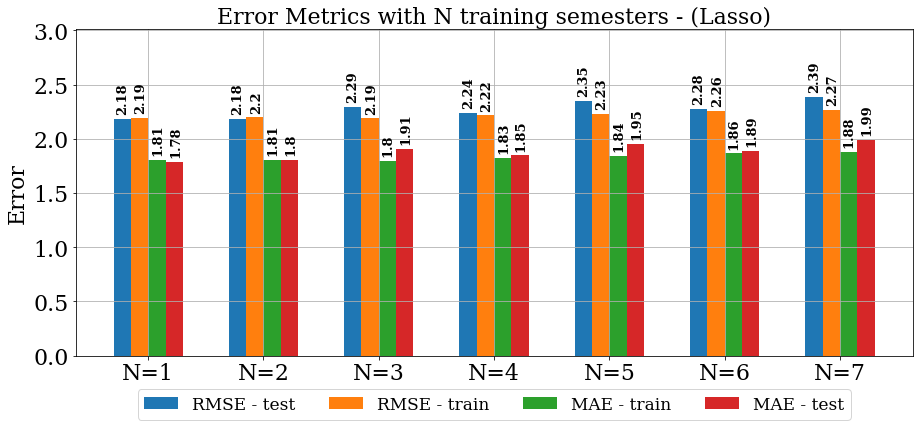

In [17]:
scores = get_error_score(df, columns, Lasso())
model_results['Lasso'] = scores
plot_error_score(scores, 'Lasso')

### Ridge:
* Observations: The model does not overfit but there is high bias.

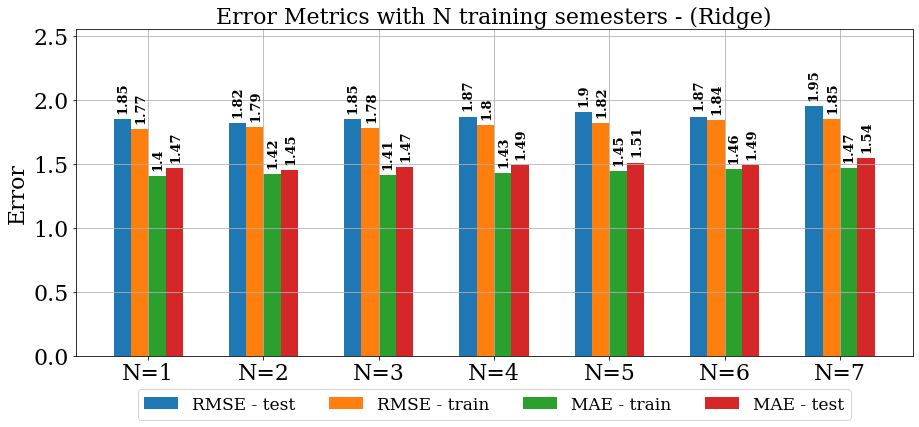

In [18]:
scores = get_error_score(df, columns, Ridge())
model_results['Ridge'] = scores
plot_error_score(scores, 'Ridge')

# Ensemble Models:
### BaggingRegressor:
* Observations: The model has both, high bias and variance.

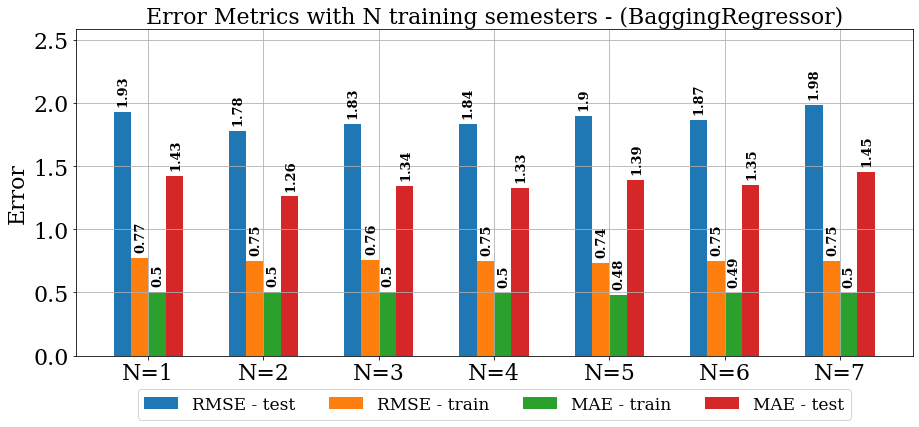

In [19]:
scores = get_error_score(df, columns, BaggingRegressor())
model_results['Bagging'] = scores
plot_error_score(scores, 'BaggingRegressor')

### AdaBoostRegressor:
* Observations: The model does not overfit but there is high bias.

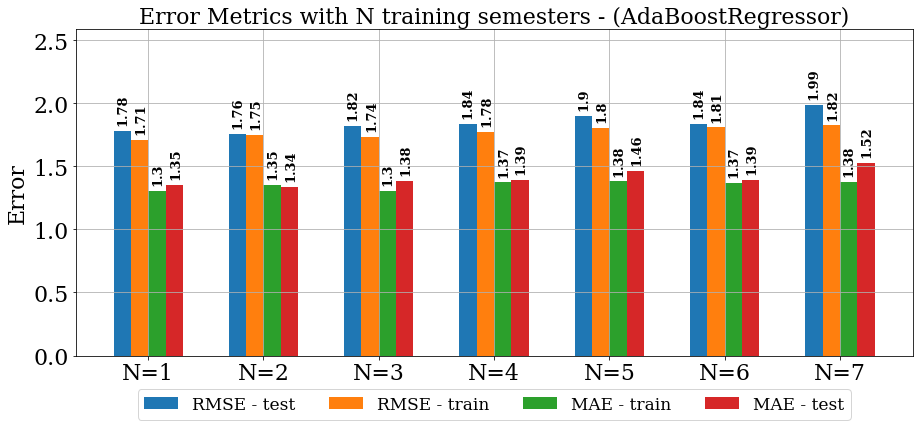

In [20]:
scores = get_error_score(df, columns, AdaBoostRegressor())
model_results['AdaBoostRegressor'] = scores
plot_error_score(scores, 'AdaBoostRegressor')

### RandomForestRegressor:
* Observations: The model has both, high bias and variance.

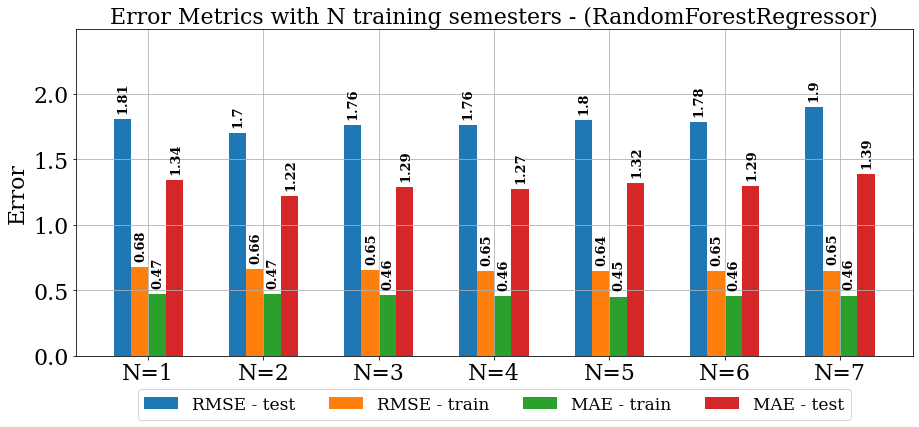

In [21]:
scores = get_error_score(df, columns, RandomForestRegressor())
model_results['RandomForestRegressor'] = scores
plot_error_score(scores, 'RandomForestRegressor')

### GradientBoostingRegressor:
* Observations: The model does not overfit but there is high bias.

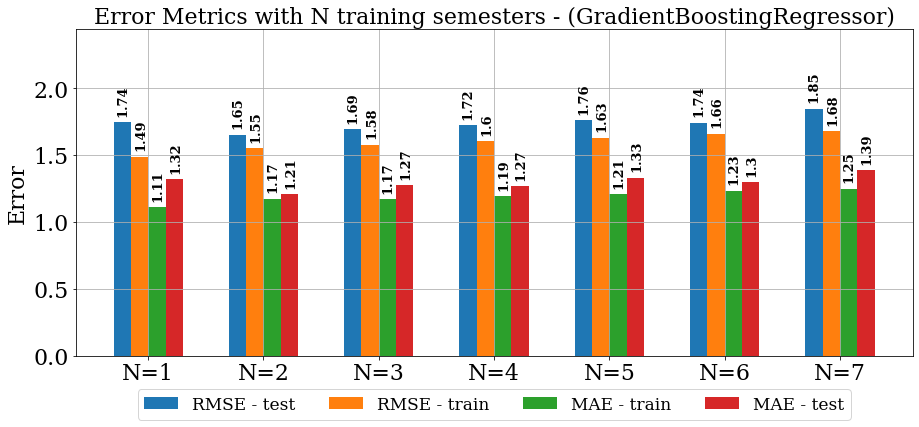

In [22]:
scores = get_error_score(df, columns, GradientBoostingRegressor())
model_results['GradientBoostingRegressor'] = scores
plot_error_score(scores, 'GradientBoostingRegressor')

In [23]:
with open('baseline_regression_results.json', 'w') as fw:
    json.dump(model_results, fw)